# HANet for handover

This notebook is to show how to train HANet and visulize the  grasping estimation.
Our network is a FCN whose backbone is ResNet-101 and pre-trianed by [ImageNet](https://www.image-net.org/download.php).

In [1]:
# default_exp model

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# export 
import torch
import torch.nn as nn
import torchvision
import copy
import cv2
import sys
import numpy as np
from handover_grasping.utils import get_model

class HANet(nn.Module):
    class FCN_model(nn.Module):
        def __init__(self, n_classes=4):
            super(HANet.FCN_model, self).__init__()
            self.color_trunk = torchvision.models.resnet101(pretrained=True)
            del self.color_trunk.fc, self.color_trunk.avgpool, self.color_trunk.layer4
            self.depth_trunk = copy.deepcopy(self.color_trunk)
            self.conv1 = nn.Conv2d(2048, 512, 1)
            self.conv2 = nn.Conv2d(512, 128, 1)
            self.conv3 = nn.Conv2d(128, n_classes, 1)
        def forward(self, color, depth):
            # Color
            color_feat_1 = self.color_trunk.conv1(color) # 3 -> 64
            color_feat_1 = self.color_trunk.bn1(color_feat_1)
            color_feat_1 = self.color_trunk.relu(color_feat_1)
            color_feat_1 = self.color_trunk.maxpool(color_feat_1)
            color_feat_2 = self.color_trunk.layer1(color_feat_1) # 64 -> 256
            color_feat_3 = self.color_trunk.layer2(color_feat_2) # 256 -> 512
            color_feat_4 = self.color_trunk.layer3(color_feat_3) # 512 -> 1024
            # Depth
            depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
            depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
            depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
            depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1)
            depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
            depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
            depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024
            # Concatenate
            feat = torch.cat([color_feat_4, depth_feat_4], dim=1) # 2048
            feat_1 = self.conv1(feat)
            feat_2 = self.conv2(feat_1)
            feat_3 = self.conv3(feat_2)
            return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)


    def __init__(self, pretrained=False, n_class=4):
        super(HANet, self).__init__()
        if pretrained == True:
            self.net = self.FCN_model(n_classes=4)
            model_path = get_model()
            self.load_state_dict(torch.load(model_path))
            print('Load pretrained complete')
        else:
            self.net = self.FCN_model(n_classes=n_class)
            
    def load(self, model_path):
        self.net.load_state_dict(torch.load(model_path))
        print('Load pretrained complete')
            
    def get_affordanceMap(self, input_color, input_depth, depth_origin):
        """Generate grasping point and affordancemap.

        This function give an affordanceMap and grasping parameters for HANet.

        Args:
          input_color (tensor): color data got from dataloader batch['color'].
          input_depth (tensor): depth data got from dataloader batch['depth']. 
          depth_origin (ndarray): depth data got from dataloader batch['depth_origin']

        Returns:
            affordanceMap, grasping 2D coordinate x and y, theta
        """
        with torch.no_grad():
            predict = self.net(input_color, input_depth)
        predict = predict.cpu().detach().numpy()
        
        Max = []
        Re = []
        Angle = [90,135,0,45]
        height = depth_origin.shape[0]
        width = depth_origin.shape[1]
        re = np.zeros((4, height, width))

        for i in range(4):
            x, y = np.where(predict[0][i] == np.max(predict[0][i]))
            re[i] = cv2.resize(predict[0][i], (width, height))
            Max.append(np.max(predict[0][i]))
            Re.append(re[i])

        theta = Angle[Max.index(max(Max))]
        graspable = re[Max.index(max(Max))]
    
        graspable = cv2.resize(graspable, (width, height))
        depth = cv2.resize(depth_origin, (width, height))
        graspable [depth==0] = 0
        graspable[graspable>=1] = 0.99999
        graspable[graspable<0] = 0
        graspable = cv2.GaussianBlur(graspable, (7, 7), 0)
        affordanceMap = (graspable/np.max(graspable)*255).astype(np.uint8)
        affordanceMap = cv2.applyColorMap(affordanceMap, cv2.COLORMAP_JET)
        affordanceMap = affordanceMap[:,:,[2,1,0]]

        gray = cv2.cvtColor(affordanceMap, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)
        binaryIMG = cv2.Canny(blurred, 20, 160)
        contours, _ = cv2.findContours(binaryIMG, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        i = 0
        point_x = 0
        point_y = 0
        cX = 0
        cY = 0
        x = 0
        y = 0

        for c in contours:        
            M = cv2.moments(c)
            if(M["m00"]!=0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                zc = depth[cY, cX]/1000
                i += 1
                point_x += cX
                point_y += cY

        if i != 0:
            x = int(point_x / i)
            y = int(point_y / i)
        else:
            x, y = np.where(predict[0][Max.index(max(Max))] == np.max(predict[0][Max.index(max(Max))]))
            x = int(x)
            y = int(y)

        return affordanceMap, x, y, theta

    def forward(self, Color, Depth):
        output = self.net(Color, Depth)

        return output
    
class HANet_depth(nn.Module):
    class FCN_model(nn.Module):
        def __init__(self, n_classes):
            super(HANet_depth.FCN_model, self).__init__()
            self.depth_trunk = torchvision.models.resnet101(pretrained=True)
            del self.depth_trunk.fc, self.depth_trunk.avgpool, self.depth_trunk.layer4

            self.conv1 = nn.Conv2d(1024, 512, 1)
            self.conv2 = nn.Conv2d(512, 128, 1)
            self.conv3 = nn.Conv2d(128, n_classes, 1)
        def forward(self, depth):
            # depth
            depth_feat_1 = self.depth_trunk.conv1(depth) # 3 -> 64
            depth_feat_1 = self.depth_trunk.bn1(depth_feat_1)
            depth_feat_1 = self.depth_trunk.relu(depth_feat_1)
            depth_feat_1 = self.depth_trunk.maxpool(depth_feat_1) 
            depth_feat_2 = self.depth_trunk.layer1(depth_feat_1) # 64 -> 256
            depth_feat_3 = self.depth_trunk.layer2(depth_feat_2) # 256 -> 512
            depth_feat_4 = self.depth_trunk.layer3(depth_feat_3) # 512 -> 1024

            feat_1 = self.conv1(depth_feat_4)
            feat_2 = self.conv2(feat_1)
            feat_3 = self.conv3(feat_2)
            return nn.Upsample(scale_factor=2, mode="bilinear")(feat_3)

    def __init__(self, pretrained=False, n_class=4):
        super(HANet_depth, self).__init__()
        if pretrained == True:
            self.net = self.FCN_model(n_classes=4)
            model_path = get_model(True)
            self.load_state_dict(torch.load(model_path))
            print('Load pretrained complete')
        else:
            self.net = self.FCN_model(n_classes=n_class)
            
    def get_affordanceMap(self, input_depth, depth_origin):
        """Generate grasping point and affordancemap.

        This function give an affordanceMap and grasping parameters for HANet.

        Args:
          input_depth (tensor): depth data got from dataloader batch['depth']. 
          depth_origin (ndarray): depth data got from dataloader batch['depth_origin']

        Returns:
            affordanceMap, grasping 2D coordinate x and y, theta
        """
        with torch.no_grad():
            predict = self.net(input_depth)
        predict = predict.cpu().detach().numpy()
        
        Max = []
        Re = []
        Angle = [90,135,0,45]
        height = depth_origin.shape[0]
        width = depth_origin.shape[1]
        re = np.zeros((4, height, width))

        for i in range(4):
            x, y = np.where(predict[0][i] == np.max(predict[0][i]))
            re[i] = cv2.resize(predict[0][i], (width, height))
            Max.append(np.max(predict[0][i]))
            Re.append(re[i])

        theta = Angle[Max.index(max(Max))]
        graspable = re[Max.index(max(Max))]
    
        graspable = cv2.resize(graspable, (width, height))
        depth = cv2.resize(depth_origin, (width, height))
        graspable [depth==0] = 0
        graspable[graspable>=1] = 0.99999
        graspable[graspable<0] = 0
        graspable = cv2.GaussianBlur(graspable, (7, 7), 0)
        affordanceMap = (graspable/np.max(graspable)*255).astype(np.uint8)
        affordanceMap = cv2.applyColorMap(affordanceMap, cv2.COLORMAP_JET)
        affordanceMap = affordanceMap[:,:,[2,1,0]]

        gray = cv2.cvtColor(affordanceMap, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (11, 11), 0)
        binaryIMG = cv2.Canny(blurred, 20, 160)
        contours, _ = cv2.findContours(binaryIMG, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        i = 0
        point_x = 0
        point_y = 0
        cX = 0
        cY = 0
        x = 0
        y = 0

        for c in contours:        
            M = cv2.moments(c)
            if(M["m00"]!=0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                zc = depth[cY, cX]/1000
                i += 1
                point_x += cX
                point_y += cY

        if i != 0:
            x = int(point_x / i)
            y = int(point_y / i)
        else:
            x, y = np.where(predict[0][Max.index(max(Max))] == np.max(predict[0][Max.index(max(Max))]))
            x = int(x)
            y = int(y)

        return affordanceMap, x, y, theta

    def forward(self, Depth):
        output = self.net(Depth)

        return output



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Inference

In [1]:
import cv2
from matplotlib import pyplot as plt
from handover_grasping.utils import get_grasp_line

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## HANet Inference

### Import dependent libraries

In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import  DataLoader
from handover_grasping.model import HANet
from handover_grasping.datavisualizer import handover_grasping_dataset

### Load Data

Do inference on HANet Testing datasets.

#### handover_grasping_dataset(data_dir: str, mode: str, color_type: str, depth_type: str)

Define the HANet dataset
    
Parameters: 
* data_dir(str) – The PATH of the folder where data is stored. The folder should include three subfolders named 'color', 'depth', and 'depth_npy'.
* mode(str) – Define the loader is for training or inference. It could be ‘train’ or ‘test’.
* color_type(str) – The color image format. It could be ‘jpg’ or ‘png’.
* depth_type(str) – The depth image format.

Returns:
* sample(dict)

In [3]:
DATA_PATH = '/home/arg/handover_grasping/data/HA-Rotated'

dataset = handover_grasping_dataset(DATA_PATH, mode='test', color_type='jpg')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 8)

### Initial HANet (with pre-trained weight)

Load HANet with pre-trained weight trained on HANet Training datasets.

In [4]:
net = HANet(pretrained=True)
net = net.cuda()
net.eval()

Load pretrained complete


HANet(
  (net): FCN_model(
    (color_trunk): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=

### Get sample data

In [5]:
batch = next(iter(dataloader))

color = batch['color'].cuda()
depth = batch['depth'].cuda()

depth_origin = batch['depth_origin'].cpu().detach().numpy()[0]
color_origin = batch['color_origin'].cpu().detach().numpy()[0]

### Prediction and Get Affordance Map

#### get_affordanceMap(self, input_color: tensor, input_depth: tensor, depth_origin: ndarray)

This function generates an affordanceMap and grasping point for HANet.

Parameters:
* input_color(tensor) – color data got from dataloader batch['color']
* input_depth(tensor) – depth data got from dataloader batch['depth']
* depth_origin(ndarray) – depth data got from dataloader 

Returns:
* affordanceMap
* grasping 2D coordinate x and y, theta

In [6]:
affordanceMap, x, y, theta = net.get_affordanceMap(color, depth, depth_origin)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualize Prediction result

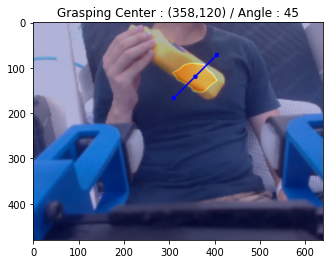

In [9]:
Combine = cv2.addWeighted(color_origin,0.7,affordanceMap, 0.3,0)
Result = cv2.resize(Combine, (640,480))
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,0,255), -1)

point1, point2 = get_grasp_line(theta, [y, x], depth_origin)

Result = cv2.line(Result,point1,point2,(0,0,255),3)
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,0,255), -1)
Result = cv2.circle(Result, point1, 5, (0,0,255), -1)
Result = cv2.circle(Result, point2, 5, (0,0,255), -1)

plt.imshow(Result)
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
plt.show()

## HANet Depth Inference

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
from torch.utils.data import  DataLoader
from handover_grasping.model import HANet_depth


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load Data

Do inference on HANet Easy Testing datasets.

In [3]:
DATA_PATH = '/home/arg/handover_grasping/data/HA-Upright'

dataset = handover_grasping_dataset(DATA_PATH, mode='test', color_type='jpg')
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 8)

### Initial HANet (with pre-trained weight)

Load HANet_depth with pre-trained weight trained on HANet Training datasets.

In [2]:
net = HANet_depth(pretrained=True)
net = net.cuda()
net.eval()

Load pretrained complete


HANet_depth(
  (net): FCN_model(
    (depth_trunk): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

### Get sample data

In [4]:
batch = next(iter(dataloader))

color = batch['color'].cuda()
depth = batch['depth'].cuda()

depth_origin = batch['depth_origin'].cpu().detach().numpy()[0]
color_origin = batch['color_origin'].cpu().detach().numpy()[0]

### Prediction and Get Affordance Map

In [5]:
affordanceMap, x, y, theta = net.get_affordanceMap(depth, depth_origin)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Visualize Prediction result

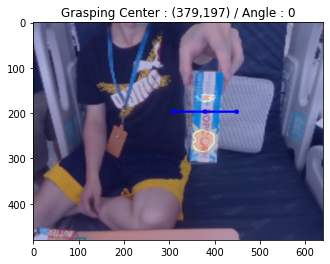

In [6]:
Combine = cv2.addWeighted(color_origin,0.7,affordanceMap, 0.3,0)
Result = cv2.resize(Combine, (640,480))
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,0,255), -1)

point1, point2 = get_grasp_line(theta, [y, x], depth_origin)

Result = cv2.line(Result,point1,point2,(0,0,255),3)
Result = cv2.circle(Result, (int(x), int(y)), 5, (0,0,255), -1)
Result = cv2.circle(Result, point1, 5, (0,0,255), -1)
Result = cv2.circle(Result, point2, 5, (0,0,255), -1)

plt.imshow(Result)
plt.title("Grasping Center : ({},{}) / Angle : {}".format(x, y, theta))
plt.show()